<div align="center">

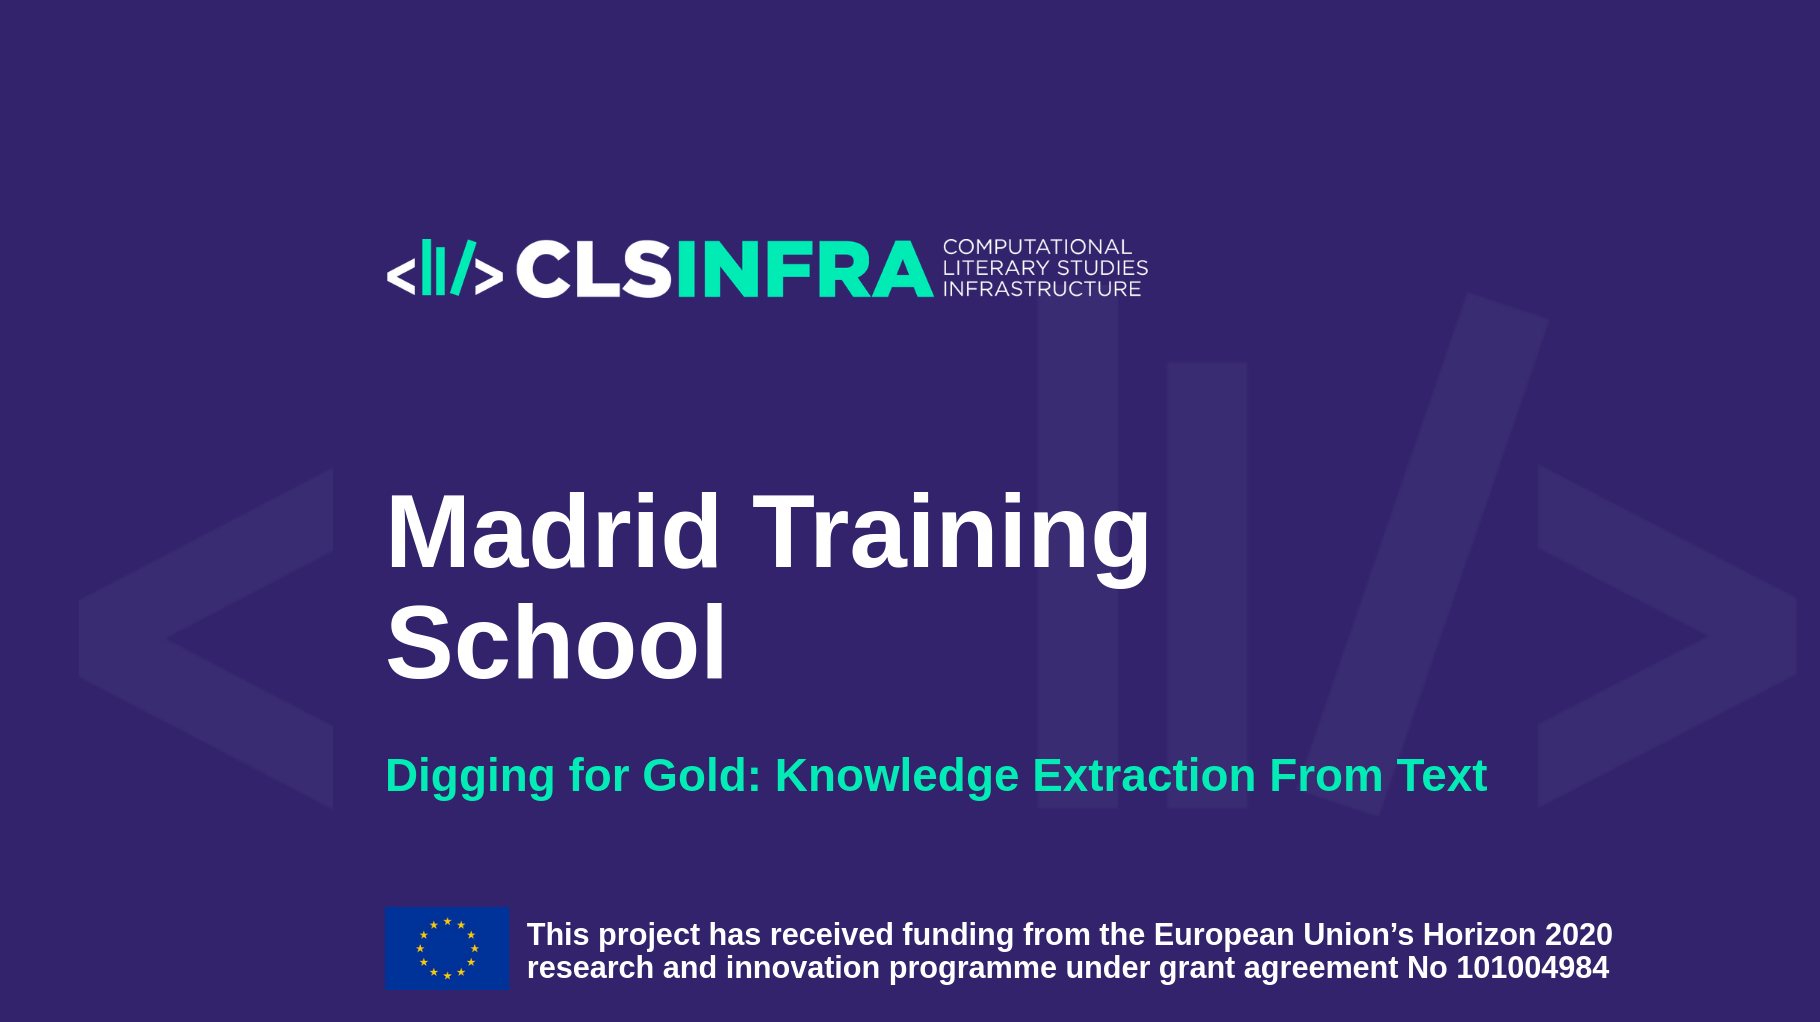
</div>

# Section I - Vector Semantics & Embeddings

---



<div align="center">

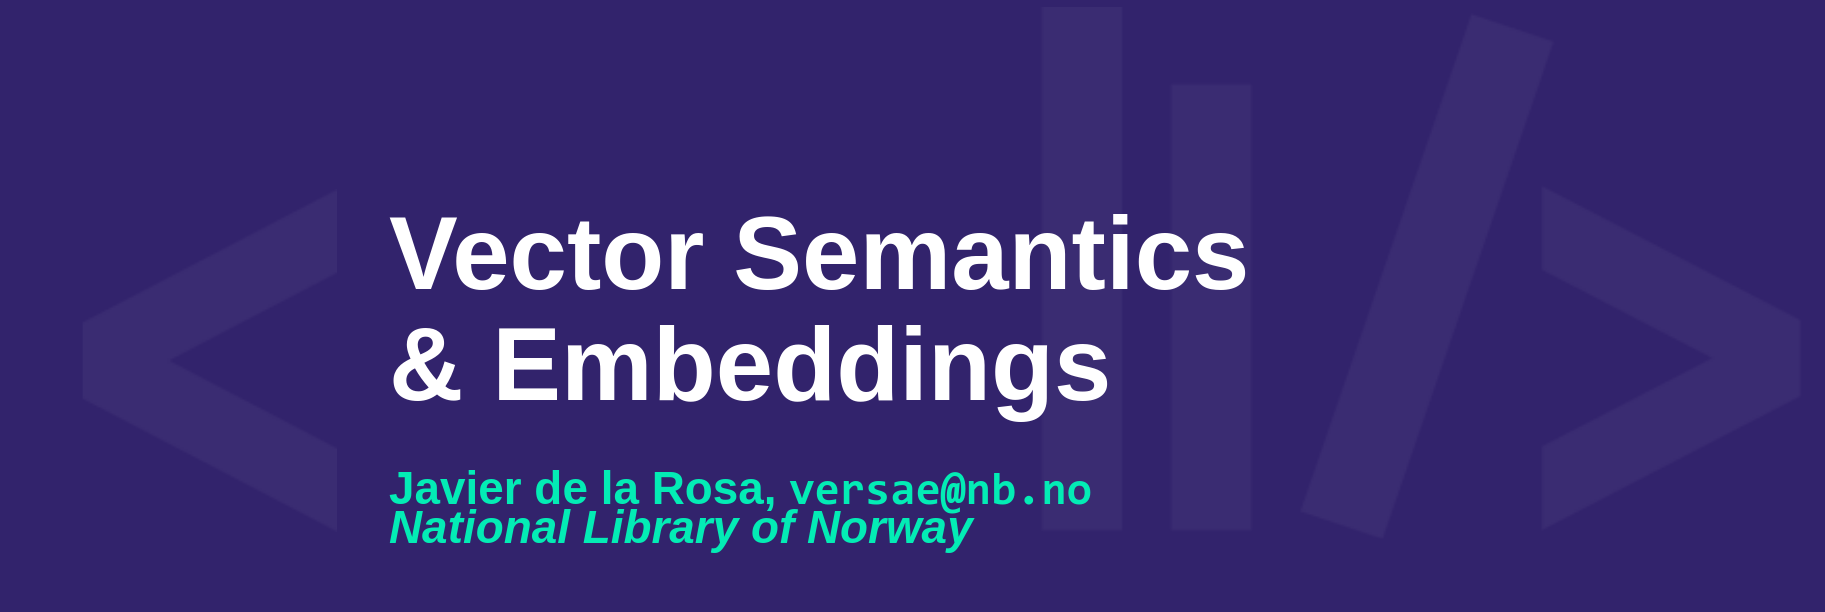
</div>

[Slides](https://docs.google.com/presentation/d/16SfV2bCQh7keNzolJRxurpn4awApOziA/edit?usp=sharing&ouid=111982612023568071558&rtpof=true&sd=true) and Notebook created by Javier de la Rosa, with contributions from [Guillermo Marco Remón](https://colab.research.google.com/drive/11AfL39t5yAmqsqCL-O5bADI4UQQACBWL#scrollTo=BbA0s8_4ID8N).

## Setup

Install and load necessary libraries .

In [ ]:
%%capture
!pip install -Uqq spacy 
!pip install -qq pandas scikit-learn datasets
!pip install -qq "simpletransformers==0.63.11" "transformers==4.28.1"
!pip install -qq gensim fasttext
!python -m spacy download en_core_web_md

In [ ]:
%%capture --no-stderr
import os
import sys
!pip install matplotlib nltk numpy tqdm
!python -m nltk.downloader all
print("Done!", file=sys.stderr)

Done!


In [ ]:
import os
import datetime
import pickle

import datasets
import fasttext
import gensim
import nltk
import numpy as np
import pandas as pd
import spacy
import transformers
from tqdm import tqdm


lang_model = "en_core_web_md"
nlp = spacy.load(lang_model)
nlp.max_length = 2_000_000
print("spacy:", spacy.__version__, f"({lang_model})")
print("pandas:", pd.__version__)
print("transformers:", transformers.__version__)
START = datetime.datetime.now()
print(START)

spacy: 3.5.2 (en_core_web_md)
pandas: 1.5.3
transformers: 4.28.1
2023-05-10 09:12:21.822038


In [ ]:
#@title Downloading all necessary files (this will take ~15mins)
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

filename = 'wiki.so.vec'
if not os.path.isfile(filename):
    print(f"Downloading {filename}")
    !curl --progress-bar -Lo $filename https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/$filename
# This might take a while
filename = 'wiki.simple.zip'
if (not os.path.isfile(filename)
        and not os.path.isfile(filename.replace('.zip', '.vec'))
        and not os.path.isfile(filename.replace('.zip', '.bin'))):
    print(f"Downloading {filename}")
    !curl --progress-bar -Lo $filename https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/$filename
if (os.path.isfile(filename)
        and (not os.path.isfile(filename.replace('.zip', '.vec'))
                 or not os.path.isfile(filename.replace('.zip', '.bin')))):
    !unzip $filename

# Downloading and preparing the pre-trained embeddings
import gensim.downloader as pretrained

pretrained.load('fasttext-wiki-news-subwords-300', return_path=True)
pretrained.load('word2vec-google-news-300', return_path=True)  # return_path avoids to load the model in memory

for filename, dirname in (('eng-fiction-all_sgns.zip', 'fiction'),
                          ('coha-word_sgns.zip', 'coha')):
    if (not os.path.isfile(filename)
            and not os.path.isdir(dirname)):
        print(f'Downloading {filename}')
        !curl --progress-bar -Lo $filename http://snap.stanford.edu/historical_embeddings/$filename
    if (os.path.isfile(filename)
            and not os.path.isdir(dirname)):
        print(f'Uncompressing {filename}')
        !unzip -q -o $filename -d $dirname

for corpus, years in (('fiction', (1900, 1950)),  # range(1800, 1991, 10)
                      ('coha', (1900, 1950))):  # range(1810, 2001, 10)
    for year in tqdm(list(years), desc=f'Generating vector files - {corpus}'):
        if os.path.isfile(f'{corpus}/{year}.vec'):
            continue
        with open(f'{corpus}/{year}.vec', 'w', encoding="utf8") as vector_file:
            vectors = np.load(open(f'{corpus}/sgns/{year}-w.npy', 'rb'))
            words = pickle.load(open(f'{corpus}/sgns/{year}-vocab.pkl', 'rb'))
            vector_file.write("{} {}".format(*vectors.shape))
            for index, word in enumerate(words):
                vector = np.array2string(vectors[index],
                                         formatter={'float_kind':'{0:.9f}'.format})[1:-1]
                vector = vector.replace('\n', '')
                vector_file.write(f'\n{word} {vector}')

######################################################################## 100.0%
######################################################################## 100.0%
Archive:  wiki.simple.zip
  inflating: wiki.simple.vec         
  inflating: wiki.simple.bin         
[==================================================] 100.0% 958.5/958.4MB downloaded
[==================================================] 100.0% 1662.8/1662.8MB downloaded
######################################################################## 100.0%
Uncompressing eng-fiction-all_sgns.zip
######################################################################## 100.0%
Uncompressing coha-word_sgns.zip


Generating vector files - coha: 100%|██████████| 2/2 [00:53<00:00, 26.67s/it]


## Word Embeddings or Word Vectors



### What is a word vector?
A word vector is a numerical representation of a word in a corpus based on its co-occurrence with other words. It is based on the distributional hypothesis, which originates from the semantic theory of linguistic use, and argues that words that are used and appear in the same contexts tend to convey similar meanings, that is to say "you shall know a word by the company it keeps", as defined by Firth in 1957.

### But, what is a vector?
A vector is nothing more than a list or an array of real numbers. The length of a vector indicates how many numbers it contains. In Python, vectors can be defined using square brackets `[]`, although formally, lists in Python can contain different types of data simultaneously.


In [ ]:
vector_one = [1, 2, 3]
vector_two = [1, 2, 34.53222222]
vector_three = [-2494, 3, 48.2934, -0.49484]

In [ ]:
vector_one + vector_two

[1, 2, 3, 1, 2, 34.53222222]

In [ ]:
np.array([1, 2, 3]) + np.array([1, 2, 3])

array([2, 4, 6])

Although it may seem convenient, performing vector operations using only lists is not easily achievable. NumPy provides a numerical engine with suitable and fast implementations for vector and matrix operations (vectors of vectors).

For example, NumPy allows generating a vector of floating-point numbers using the `randn()` function. Each time it is executed, a different vector is obtained.


In [ ]:
random_vector = np.random.randn(5)
random_vector

array([-0.01984349,  1.14786729, -1.69092991, -0.21268444, -0.45151004])

NumPy provides a numerical engine with appropriate and fast implementations for operations on vectors and matrices (vectors of vectors).


In [ ]:
# vector of 10 integers between 0 and 9
np.random.randint(0, 10, size=10)

array([0, 0, 2, 7, 6, 0, 6, 4, 1, 1])

In [ ]:
# dot product of 2 vectors
np.random.randint(0, 10, size=10) @ np.random.randint(0, 10, size=10)

161

In [ ]:
# vector product
np.random.randint(0, 10, size=10) * np.random.randint(0, 10, size=10)

array([10, 32,  8, 27,  0, 54, 42, 18, 63, 16])

### Calculating word vectors

Word vectors (and vectors in general) are classified as sparse (when they have many `0`s) or dense (when almost all values are non-zero). For vectors representing co-occurrences or frequencies, it is quite common for many words not to appear together or for many words to occur in only a few documents. As a result, these vectors tend to have many `0`s.


Let's see how we can build these vectors, from the most basic ones based on counting to more complex structures that encode part of the semantics of a word. Of the many existing packages to assist in the construction of matrices for a corpus, `scikit-learn` is one of the most widely used and a common component in the Python scientific stack. So let's import `CountVectorizer()` from `scikit-learn`.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Let's imagine that we have a document with a single sentence
documents = [
    "This is a piece of text. This is also some random text. Also text.",
]

Now let's transform the document so that each word is assigned a unique identifier.

In [ ]:
example_vectorizer = CountVectorizer()
example_vectorizer.fit(documents)
print("Vocabulary size:", len(example_vectorizer.vocabulary_))
example_vectorizer.vocabulary_

Vocabulary size: 8


{'this': 7,
 'is': 1,
 'piece': 3,
 'of': 2,
 'text': 6,
 'also': 0,
 'some': 5,
 'random': 4}

In addition, we add the corresponding value of the absolute frequency, that is, the total number of times that each word appears in the document.

In [ ]:
counts = example_vectorizer.transform(documents)
print(counts)
print("   ↑  ↑         ↑\n  doc word_id freq")

  (0, 0)	2
  (0, 1)	2
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 6)	3
  (0, 7)	2
   ↑  ↑         ↑
  doc word_id freq


Now we can go through all the words that appear in our original document and print all the frequencies that we have generated above.

In [ ]:
doc = 0  # first document only
for word, word_id in example_vectorizer.vocabulary_.items():
    print(word, ":", counts[doc, word_id])

this : 2
is : 2
piece : 1
of : 1
text : 3
also : 2
some : 1
random : 1


### Doc-term matrix

A **document-term matrix** is nothing more than a relatively large table that describes the frequency of words or terms that appear in a collection of documents.
In a document-term matrix, **rows correspond to the documents** in the collection or corpus, and **columns to the terms**.


In our case, since we only have a single document, our document-term array would only have one file (document `0`).

| | also | is | of | piece | random | some | text | this |
| ------------ |:----:|:--:|:--:|:-----:|:------:|:----:|:----:|:----:|
| Document #0 | 2 | 2 | 1 | 1 | 1 | 1 | 3 | 2 |

As we have seen, it corresponds directly to the output of the `transform()` method of our `CountVectorizer()`.

In [ ]:
counts = example_vectorizer.transform(documents)
counts.toarray()

array([[2, 2, 1, 1, 1, 1, 3, 2]])

Each element of the array represents a term from the above vocabulary, using the indices that `scikit-learn` has randomly assigned, eg the seventh element (sixth, since it starts with 0) is the word `text`.

Let's now add a new document that is almost identical but introduces a new word to our vocabulary, just to see how this change affects the matrix.

In [ ]:
documents = [
    "This is a piece of text. This is also some random text. Also text.",
    "This is a piece of text. This is also some random text. Also new text.",
]
example_vectorizer.fit(documents)
print("Vocabulary size:", len(example_vectorizer.vocabulary_))
example_vectorizer.vocabulary_

Vocabulary size: 9


{'this': 8,
 'is': 1,
 'piece': 4,
 'of': 3,
 'text': 7,
 'also': 0,
 'some': 6,
 'random': 5,
 'new': 2}

In [ ]:
counts = example_vectorizer.transform(documents)
print(counts)
print("   ↑  ↑         ↑\n  doc word_id freq")

  (0, 0)	2
  (0, 1)	2
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	3
  (0, 8)	2
  (1, 0)	2
  (1, 1)	2
  (1, 2)	1
  (1, 3)	1
  (1, 4)	1
  (1, 5)	1
  (1, 6)	1
  (1, 7)	3
  (1, 8)	2
   ↑  ↑         ↑
  doc word_id freq


In [ ]:
counts = example_vectorizer.transform(documents)
counts.toarray()

array([[2, 2, 0, 1, 1, 1, 1, 3, 2],
       [2, 2, 1, 1, 1, 1, 1, 3, 2]])

Now, with two documents, our matrix would look something like this.

| | also | is | new | of | piece | random | some | text | this |
| ------------ |:----:|:--:|:---:|:--:|:-----:|:------:|:----:|:----:|:----:|
| Document #0 | 2 | 2 | 0 | 1 | 1 | 1 | 1 | 3 | 2 |
| Document #1 | 2 | 2 | 1 | 1 | 1 | 1 | 1 | 3 | 2 |

In addition to the fact that the size of the vocabulary is now larger, just by looking at the document-term matrix we can easily identify that one of our documents has one more word than the other. Indeed, we can see the difference in column 3 (2 since it's indexed at 0), which corresponds to the newly introduced word, `new`, in our vocabulary. There is also a new row for the additional document (document `1`). And this is just one example, imagine with a corpus of thousands of documents and hundreds of thousands of words!

By now, you may have noticed that one-letter words are being ignored. This is due to the way `CountVectorizer()` splits sentences into words. `CountVectorizer()` has options to customize this behavior and allows you to specify your own regular expression to extract words, ignore stopwords (*stopwords*), count n-grams instead of words, limit the maximum number of words to count, normalize spelling, or counting terms in a frequency range. The rich [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) is worth exploring.

In [ ]:
new_regex = r"(?u)\b\w+\b"  # regular expression so single letter words are not ignored
CountVectorizer(token_pattern=new_regex).fit(documents).vocabulary_

{'this': 9,
 'is': 2,
 'a': 0,
 'piece': 5,
 'of': 4,
 'text': 8,
 'also': 1,
 'some': 7,
 'random': 6,
 'new': 3}

For the following example we will use the novels Moby Dick, Emma, and Alice in Wonderland as the example texts of our corpus, taking advantage of the fact that they are already digitized in NLTK.

In [ ]:
from nltk.corpus import gutenberg

In [ ]:
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [ ]:
mobydick = gutenberg.raw('melville-moby_dick.txt')
emma = gutenberg.raw('austen-emma.txt')
alice = gutenberg.raw('carroll-alice.txt')

Number of tokens in Moby Dick.

In [ ]:
len(mobydick.split())

212030

In [ ]:
print(emma[:200], "...")

[Emma by Jane Austen 1816]

VOLUME I

CHAPTER I


Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings
of existence; an ...


We define our corpus as the list of the texts of the three novels.

In [ ]:
corpus = [mobydick, emma, alice]

We create our `CountVectorizer()`

In [ ]:
lit_vectorizer = CountVectorizer(token_pattern=new_regex)
lit_vectorizer.fit(corpus)
print("Vocabulary size:", len(lit_vectorizer.vocabulary_))

list(lit_vectorizer.vocabulary_.items())[:10]

Vocabulary size: 19918


[('moby', 11293),
 ('dick', 5069),
 ('by', 2661),
 ('herman', 8441),
 ('melville', 11046),
 ('1851', 83),
 ('etymology', 6264),
 ('supplied', 17060),
 ('a', 364),
 ('late', 10165)]

In [ ]:
print("The word id for 'piece' is", str(lit_vectorizer.vocabulary_.get('piece')))

The word id for 'piece' is 12886


Let's see how the doc-term matrix looks

In [ ]:
X = lit_vectorizer.fit_transform(corpus)
X

<3x19918 sparse matrix of type '<class 'numpy.int64'>'
	with 26967 stored elements in Compressed Sparse Row format>

In [ ]:
X = X.toarray()
X

array([[20,  2,  4, ...,  3,  2,  1],
       [ 2,  0,  2, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [ ]:
"{} documents with a vocabulary of {} words".format(*X.shape)

'3 documents with a vocabulary of 19918 words'

In [ ]:
f"{np.prod(X.shape)} elements in our matrix"

'59754 elements in our matrix'

In [ ]:
f"Out of which, {np.count_nonzero(X==0)} are zeros"

'Out of which, 32787 are zeros'

In [ ]:
# Vocabulary example words
lit_vectorizer.get_feature_names_out()[1000:1010]

array(['animate', 'animated', 'animating', 'animation', 'animosity',
       'ankers', 'ankles', 'ann', 'anna', 'annals'], dtype=object)

Get the identifiers of some words.

In [ ]:
print(lit_vectorizer.vocabulary_.get('happy'))
print(lit_vectorizer.vocabulary_.get('sad'))
print(lit_vectorizer.vocabulary_.get('angry'))
print(lit_vectorizer.vocabulary_.get('queer'))
print(lit_vectorizer.vocabulary_.get('handkerchief'))

8172
14929
994
13872
8139


And let's use them to see how many times they appear in the corpus, that is, what their **vectors** are.

In [ ]:
X[:,8172], X[:,14929], X[:,994], X[:,13872], X[:,8139]

(array([  8, 125,   1]),
 array([ 9, 25,  3]),
 array([ 1, 19,  5]),
 array([44,  0, 12]),
 array([5, 0, 0]))

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

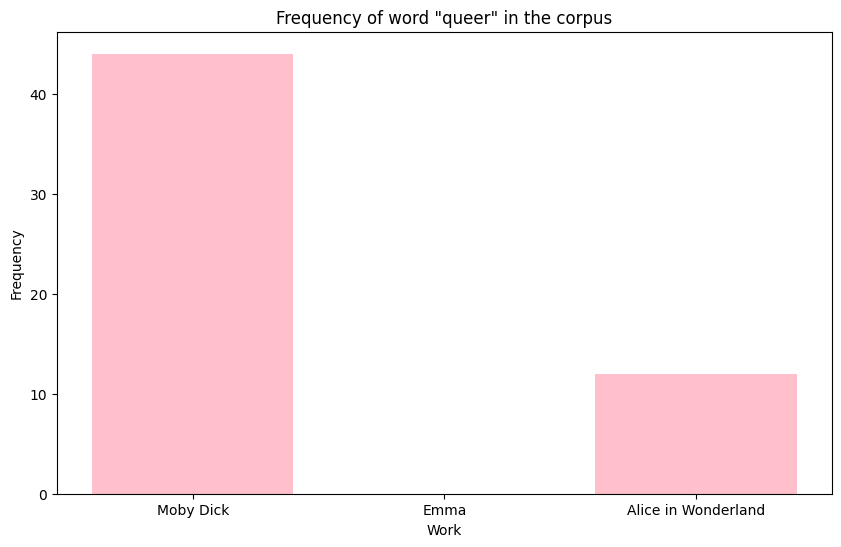

In [ ]:
freq_of_queer = X[:,lit_vectorizer.vocabulary_.get('queer')]
x = np.arange(len(freq_of_queer))
plt.figure(figsize=(10, 6))
plt.bar(x, freq_of_queer, color="pink")
plt.xticks(x, ('Moby Dick', 'Emma', 'Alice in Wonderland'))
plt.xlabel('Work')
plt.ylabel('Frequency')
plt.title('Frequency of word "queer" in the corpus');

### Word-word or term-term matrix

We have seen how words are represented based on their relationships in a corpus of documents. But what about the relationship between them? The most intuitive way to do this comparison is to build a word-word matrix in which the two dimensions are the vocabulary of the corpus and each element represents the co-occurrence of two vocabulary terms in an arbitrary window. This window indicates the number of words before and after the given word that we use to count co-occurrences. As a general rule, this window usually has a size between 4 and 10.

In [ ]:
from scipy import sparse

def ww_matrix(corpus, tokenizer, window_size):
    vocabulary = {}
    data = []
    row = []
    col = []
    for sentence in corpus:
        sentence=sentence.strip()
        tokens=[token for token in tokenizer(sentence) if token != u""]
        for pos,token in enumerate(tokens):
            i = vocabulary.setdefault(token,len(vocabulary))
            start = max(0, pos - window_size)
            end = min(len(tokens), pos + window_size + 1)
            for pos2 in range(start, end):
                if pos2 == pos: 
                    continue
                j = vocabulary.setdefault(tokens[pos2], len(vocabulary))
                data.append(1.); row.append(i); col.append(j);
    cooccurrence_matrix = sparse.coo_matrix((data, (row, col)))
    return vocabulary, cooccurrence_matrix

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
a = ['I love Programming. I love Math. I tolerate Biology.']

In this case, the word "love" is defined by the words "I" and "Programming", its neighbors 1 word away, which means that we must increment the value of the co-occurrences ("I", "love") and ("love", "Pogramming"). We repeat the process for each window and obtain the co-occurrence matrix.

In [ ]:
v, m = ww_matrix(a, word_tokenize, 1)
m.toarray(), v

(array([[0., 2., 0., 2., 0., 1., 0.],
        [2., 0., 1., 0., 1., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0.],
        [2., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1., 0.]]),
 {'I': 0,
  'love': 1,
  'Programming': 2,
  '.': 3,
  'Math': 4,
  'tolerate': 5,
  'Biology': 6})

In [ ]:
columns = [x[0] for x in sorted(v.items(), key=lambda x: x[1])]
pd.DataFrame(m.toarray(), index=columns, columns=columns).astype(int)

,I,love,Programming,.,Math,tolerate,Biology
I,0,2,0,2,0,1,0
love,2,0,1,0,1,0,0
Programming,0,1,0,1,0,0,0
.,2,0,1,0,1,0,1
Math,0,1,0,1,0,0,0
tolerate,1,0,0,0,0,0,1
Biology,0,0,0,1,0,1,0


Once we have the word-word matrix filled in, we can represent the result in a multi-dimensional space. Since both "Programming" and "Math" **have the same co-occurrence values, they will be located in the same place**; which means that in this context they **mean the same thing**, or almost the same thing. The syntactic and semantic relations generated by this technique are really powerful, but computationally very expensive to produce since we are dealing with dimensional spaces with a large number of dimensions. Therefore, we need some technique to reduce dimensionality.

In [ ]:
# Let's see Moby Dick
mobydick = gutenberg.raw('melville-moby_dick.txt')
v, m = ww_matrix([mobydick], word_tokenize, 4) 
X = m.toarray()
X

array([[ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  2., 84., ...,  0.,  0.,  0.],
       [ 1., 84.,  4., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [ ]:
X = m.toarray()
X.shape

(20742, 20742)

In [ ]:
# Let's get the vectors for 'happy','sad','angry'
happy_i = v['happy']
sad_i = v['sad']
angry_i = v['angry']

In [ ]:
happy_ww = X[happy_i,:]
sad_ww = X[sad_i,:]
angry_ww = X[angry_i,:]
# np.set_printoptions(threshold=np.inf)
happy_ww

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
X[happy_i, sad_i]

0.0

How many times do "dark" and "night" co-occur with a window of 4?

In [ ]:
dark_i = v['dark']
stormy_i = v['stormy']
night_i = v['night']

X[dark_i, night_i]

3.0

### Singular Value Decomposition

The idea of this technique is to store only the most "important" information, removing as many zeros as possible, and keeping only the resulting values in a denser representation with fewer dimensions. SVD is therefore a dimensionality reduction technique that comes from linear algebra and that decomposes matrices into n eigenvectors, which can be applied to word-word matrices.

Fortunately, scikit-learn has native support for this technique.

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=10)  # Truncated means the only keep K dimensions

In [ ]:
denseX = svd.fit_transform(X)  # n_samples, n_dims

In [ ]:
denseX.shape

(20742, 10)

In [ ]:
eigen = svd.fit(X).explained_variance_
eigen

array([2.78012626e+04, 8.65125988e+02, 3.88478657e+02, 3.37794372e+02,
       1.90124254e+02, 1.45641386e+02, 5.66931667e+01, 3.05512340e+01,
       2.48838336e+01, 2.23263397e+01])

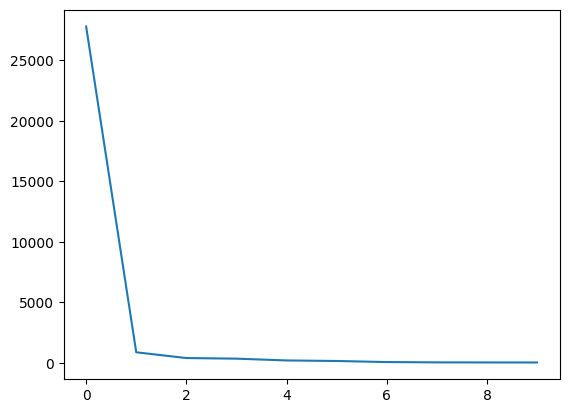

In [ ]:
# Most of the variance is encoded in the first dimension
plt.plot(eigen)

In [ ]:
happy_vector_dense = denseX[v['happy'],:]
sad_vector_dense = denseX[v['sad'],:]
angry_vector_dense = denseX[v['angry'],:]

In [ ]:
happy_vector_dense

array([ 6.45130788,  1.27333707, -0.98429298, -1.68135076, -0.94632099,
       -2.50991999, -0.77464334,  0.40030684,  0.51412982,  0.62078147])

In [ ]:
happy_ww

array([0., 0., 0., ..., 0., 0., 0.])

Semantically, SVD allows us to group similar concepts together and operate on them to find similarities.

### Vector similarity

There are different ways to measure the distance between two vectors. Perhaps the most widely used is **cosine similarity**, which is based on the angle between two vectors in their vector space.

$$cos(\vec{v}, \vec{w}) = \frac{dot(\vec{v},\vec{w})}{norm(\vec{v})norm(\vec{w})}$$

$$dot(\vec{v},\vec{w}) = \sum_{i=0}^{n}v_iw_i$$
$$norm(\vec{v}) = \sqrt{\sum_{i=0}^{n}v_i^2}$$

It is necessary to normalize to avoid dealing with absolute frequencies in the calculation of the distance.

The cosine similarity ranges from -1 to 1, where 1 means close in direction, -1 in the opposite direction, and 0 means that the vectors are orthogonal.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
index = v['elated']
elated_vector_dense = denseX[index,:]

In [ ]:
happy_vector = happy_vector_dense.reshape(1,-1) 
sad_vector = sad_vector_dense.reshape(1,-1)
angry_vector = angry_vector_dense.reshape(1,-1)
elated_vector = elated_vector_dense.reshape(1,-1)

In [ ]:
# Angle between happy and sad
cosine_similarity(happy_vector, sad_vector)

array([[0.84350693]])

In [ ]:
cosine_similarity(angry_vector, sad_vector)

array([[0.37021468]])

In [ ]:
cosine_similarity(happy_vector, angry_vector)

array([[0.43307952]])

In [ ]:
cosine_similarity(happy_vector, elated_vector)

array([[0.76713106]])

In [ ]:
whale_i = v['whale']
harpoon_i = v['harpoon']
boat_i = v['boat']
blood_i = v['blood']
cosine_similarity(denseX[boat_i,:].reshape(1,-1), denseX[harpoon_i,:].reshape(1,-1))

array([[0.98147965]])

Finally, let's plot the semantic closeness according to SVD and t-SNE (another dimensionality reduction technique) to see it better.

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

In [ ]:
# Let's use just 50 random words
random_indices = np.random.choice(len(v), 50, replace=False)
select_matrix = X[random_indices]
lookup = {val:key for key,val in v.items()}
labels = [lookup[w] for w in random_indices]

In [ ]:
select_matrix.shape

(50, 20742)

In [ ]:
labels

['intensifying',
 'Bunger',
 'impregnated',
 'labelled',
 'repelling',
 'rare',
 'scorched',
 'greatness',
 'perch',
 'headmost',
 'indefatigable',
 'cherish',
 'Gemini',
 'Northern',
 'garden-chairs',
 'loaf-of-bread',
 'rascally',
 'eh',
 'screwing',
 'prince',
 'cloak',
 'calculate',
 'talks',
 'speechless',
 'verifications',
 'hatches',
 'handled',
 'mid-watch',
 'watching',
 'constant',
 'sweeter',
 'MULTUM',
 'Sleep',
 'satirizing',
 'rostrated',
 'golden',
 'South-Sea',
 'boarders',
 'Hither',
 'served',
 'cove',
 'spars',
 'inquiring',
 'original',
 'Certainly',
 'comprehensive',
 'Broadway',
 'Insurance',
 'sagacity',
 'member-roll']

In [ ]:
embed = tsne.fit_transform(select_matrix)

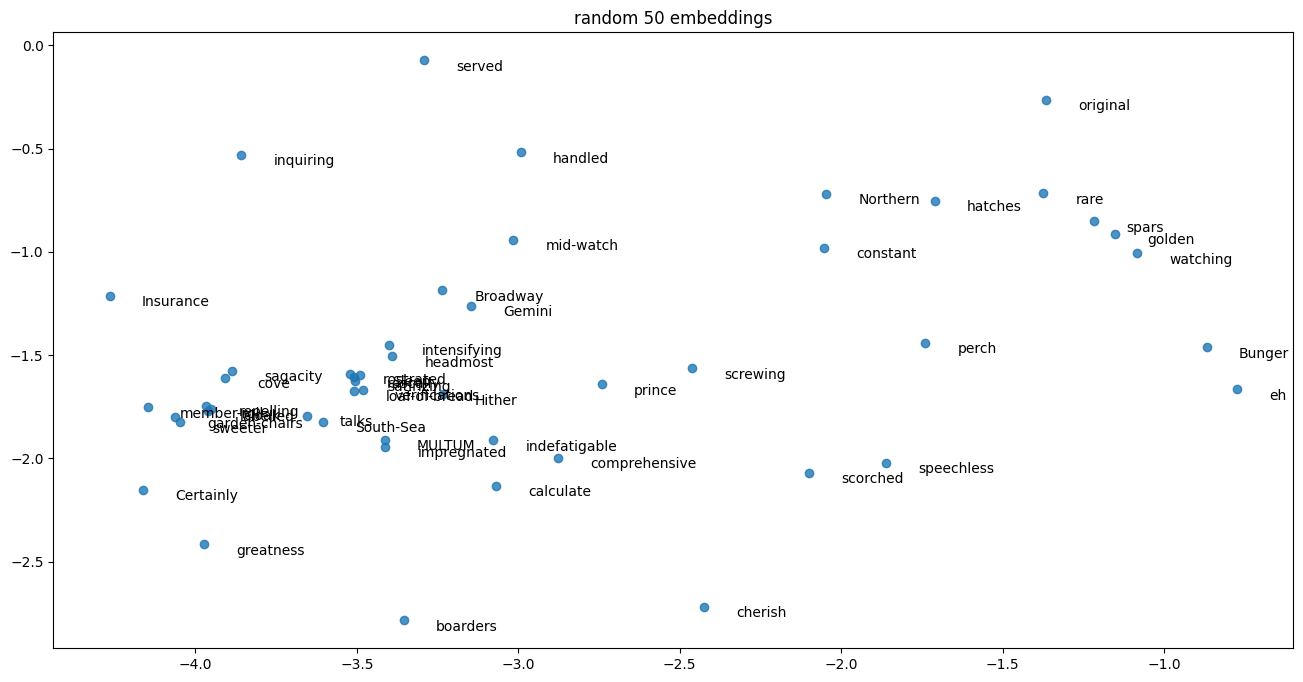

In [ ]:
random_x, random_y = zip(*embed)
fig, ax = plt.subplots(figsize=(16, 8))
ax.scatter(random_x, random_y, alpha=.8)

for _, lab in enumerate(labels):
    ax.annotate(lab, (random_x[_]+.1, random_y[_]-.05))

plt.title("random 50 embeddings")
plt.show()

In SpaCy, there is an integrated type of word embeddings, the word2vec, whose behavior is similar to what was previously seen.

In [ ]:
tokens = nlp("this is just a test")

for token in tokens:
    print(token, token.has_vector, token.vector)

this True [ 2.1790e+00  4.3820e+00 -3.6766e+00 -3.0660e+00  4.6297e+00 -3.5691e-01
  2.7313e+00  1.0662e+00 -3.0959e+00  1.5092e+00  8.9701e+00  2.9807e+00
 -6.5008e+00  1.1712e+00  2.2440e+00 -2.2113e+00  7.8061e+00 -1.2843e+00
 -9.4817e-02  2.4967e+00  1.5562e+00  2.3749e+00  3.3589e-01 -1.7089e+00
 -3.2103e+00 -3.4550e-03 -4.9608e+00  1.7484e+00 -2.6195e+00  3.8560e+00
  3.6573e+00 -3.0178e+00  2.7788e-01 -3.0669e+00 -2.5086e+00 -2.4589e+00
 -1.0248e+00  1.3385e+00  8.4223e+00  2.0983e+00 -4.1140e+00  4.0198e+00
  2.9452e+00 -3.8445e+00 -2.2845e+00  2.1215e+00  4.8161e-01 -1.8626e+00
 -2.3568e+00  1.6330e+00  9.6536e-01 -7.2313e-01  4.7061e-01 -3.9073e+00
 -4.6706e+00 -4.9007e-01  1.2078e+00  2.8372e+00  4.8466e-01  2.2047e+00
  3.6709e+00  1.9159e+00  5.5928e-01 -1.7662e+00 -1.2666e+00  4.7163e+00
 -4.8360e+00 -4.9148e+00  3.6826e+00  1.6398e+00  1.3555e-01  4.9553e+00
 -1.6841e+00 -2.8694e+00 -2.1086e+00  4.5669e+00 -1.0767e+00  2.8345e-01
 -3.1082e+00 -4.8376e-01 -2.2490e+00  1.4

In [ ]:
tokens = nlp("this is just a test")

for token1 in tokens:
    for token2 in tokens:
        print(token1.text, token2.text, token1.similarity(token2))

this this 1.0
this is 0.27932846546173096
this just 0.5840269327163696
this a 0.5156261324882507
this test 0.3058573007583618
is this 0.27932846546173096
is is 1.0
is just 0.10397733747959137
is a 0.2897643446922302
is test 0.15232251584529877
just this 0.5840269327163696
just is 0.10397733747959137
just just 1.0
just a 0.28993508219718933
just test 0.25989341735839844
a this 0.5156261324882507
a is 0.2897643446922302
a just 0.28993508219718933
a a 1.0
a test 0.16575178503990173
test this 0.3058573007583618
test is 0.15232251584529877
test just 0.25989341735839844
test a 0.16575178503990173
test test 1.0


And a quick way to see if two lines, paragraphs, or even documents are talking about the same things is by comparing the vector averages of the words that compose them.

In [ ]:
def document_similarity(doc1, doc2):
    doc1_doc = nlp(doc1)
    doc1_vectors = [token.vector for token in doc1_doc if token.has_vector]
    doc1_avg = sum(doc1_vectors) / len(doc1_vectors)

    doc2_doc = nlp(doc2)
    doc2_vectors = [token.vector for token in doc2_doc if token.has_vector]
    doc2_avg = sum(doc2_vectors) / len(doc2_vectors)

    return cosine_similarity([doc1_avg], [doc2_avg])


document_similarity(alice, mobydick)

array([[0.94939755]])

### Out-of-vocabulary words and pre-trained embeddings

So far, we've seen the power of word embeddings and how easy they are to obtain from your own corpus. In most cases, however, we do not have access to millions of unlabelled documents in our target domain that would allow for training good embeddings from scratch. Training word embeddings is very resource intensive and it may require relatively large corpora for the geometric relationships to be semantically meaningful. Still, there are some issues with regular word-oriented embeddings. To illustrate this, consider the next code that trains on the text from _Alice in Wonderland_.

In [ ]:
print(nltk.corpus.gutenberg.raw('carroll-alice.txt')[0:200])

[Alice's Adventures in Wonderland by Lewis Carroll 1865]

CHAPTER I. Down the Rabbit-Hole

Alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once


We'll use the handy `.words()` method in NLTK to access just the words.

In [ ]:
words = list(map(str.lower, nltk.corpus.gutenberg.words('carroll-alice.txt')))
words[:10]

['[',
 'alice',
 "'",
 's',
 'adventures',
 'in',
 'wonderland',
 'by',
 'lewis',
 'carroll']

And now let's train a very simple `word2vec` model.

In [ ]:
documents = [words]
model = gensim.models.Word2Vec(
    documents,
    vector_size=25,
    window=5,
    min_count=1,
    workers=10
)
model.train(documents, total_examples=len(documents), epochs=10)
model.wv['alice']

array([ 0.6676179 , -0.5672889 ,  1.0525128 , -0.5539267 , -0.06483321,
       -0.62139404,  0.48843703,  0.85565853, -1.8262287 , -1.8770187 ,
        0.4473904 , -0.16455913,  1.324805  ,  0.64579284, -0.2434801 ,
        1.8136393 ,  0.6461008 , -0.01515406, -1.2605448 ,  0.34128276,
        0.51824105,  1.0233902 ,  0.9341368 , -0.00327026,  0.94702256],
      dtype=float32)

Regardless of whether this model is able to compute semantic similarities or not, word vectors have been computed. However, if you try to look for words that are not in the vocabulary you'll get an error.

In [ ]:
try:
    model.wv['google']
except KeyError as e:
    print(e)

"Key 'google' not present"


This is known as the Out-Of-Vocabulary (OOV) issue in Word2Vec and similar approaches.

Now, you may think, I could get synonyms of the OOV words using something like WordNet, and then look for those words' embeddings. And while that might work in some cases, in others it is not that simple. Two such cases are new-ish words like `facebook` and `google`, or proper names of places, like `Teotihuacan`.

One way to solve this issue is to use a different measure of atomicity in your algorithm. In Word2Vec-like approaches, including GloVe, the word is the minimum unit, and as such, when looking for words that are not in the vocabulary there is certainly no vector information for it. In contrast, a different approach could train for sub-word units, for example 3-grams. While not guaranteeing that all words will be covered, a good amount of them might be, due to the fact that it's more likely for all possible trigrams to be included in a large enough corpus than all possible words. This is the approach taken by Facebook's fastText.

In [ ]:
from gensim.models import FastText

fasttext_model = FastText(documents, vector_size=25, min_count=1)
fasttext_model.wv['alice']

array([-0.88179713,  0.08437259,  1.0231214 ,  0.7556845 ,  0.2553469 ,
       -0.8949131 ,  1.4881291 ,  0.23132941, -1.5087223 , -0.09293869,
       -0.88207   ,  0.36084223,  0.99479944,  0.18355638,  0.69147605,
        1.0099419 ,  0.31685558,  0.39885667,  0.49908924,  0.08144356,
       -0.24190375,  0.32421827,  0.5341031 , -0.96770567,  0.60720646],
      dtype=float32)

In [ ]:
fasttext_model.wv['google']

array([-0.26478875,  0.02304918,  0.2977451 ,  0.23135103,  0.08648005,
       -0.26656187,  0.4500616 ,  0.06838612, -0.46663284, -0.03605212,
       -0.26074818,  0.11185655,  0.2897166 ,  0.04672479,  0.20725435,
        0.29671457,  0.08959308,  0.12265384,  0.14938882,  0.02024199,
       -0.07229203,  0.09379312,  0.15612957, -0.30305302,  0.18598478],
      dtype=float32)

fastText also distributes word vectors pre-trained on [Common Crawl](http://commoncrawl.org/) and [Wikipedia](https://www.wikipedia.org/) for more than 157 languages. These models were trained using CBOW with position-weights, in dimension 300, with character n-grams of length 5, a window of size 5 and 10 negatives. They come in binary and text format: binary includes a model ready to use while the text format only contains the actual vectors associated to each word on the training set.

Gensim is soon to include a special method to load in these fasText embeddings (not working as of 3.4.0). Just take into account that only the `.bin` format allows for OOV word vectors. For the regular and usually lighter `.vec` format you still would need to load in the vectors, save a binary Gensim model, and load it back in.

Let's see a couple of examples of using `.vec` from the Somali and the Simplified English Wikipedia corpora available for fastText. These files are loaded in using the regular Gensim `KeyedVectors` word2vec model (`.load_word2vec_format()`), and vectors for out of vocabulary cannot be computed.

In Somali, the word `xiddigta` (meaning *the star*) should have its own vector avalilable since the word is present in the corpus.

In [ ]:
filename = 'wiki.so.vec'
if not os.path.isfile(filename):
    !echo "Downloading $filename"
    !curl --progress-bar -Lo $filename https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/$filename

somali_model_wv = gensim.models.KeyedVectors.load_word2vec_format(filename, binary=False)
somali_model_wv['xiddigta'][:25]  # it means 'the star' in Somali

array([ 0.156    , -0.11243  , -0.19999  , -0.0082059,  0.053104 ,
        0.0062253, -0.15436  , -0.086891 ,  0.049946 , -0.0084536,
       -0.1547   , -0.041276 ,  0.34115  ,  0.049262 , -0.099698 ,
       -0.092703 , -0.15162  ,  0.011775 , -0.0048607, -0.0026743,
       -0.11588  , -0.051329 , -0.22717  ,  0.069633 , -0.0051629],
      dtype=float32)

But the word `ciyaalsuuq` (meaning *unruly youth*) raises a `KeyError` in the word vectors dictionary.

In [ ]:
try:
    somali_model_wv['ciyaalsuuq'][:25]
except KeyError as e:
    print(e)

"Key 'ciyaalsuuq' not present"


And the same thing occurs in English: while words like `star` are certainly available, words such as `bibliopole` (meaning *a person who buys and sells books, especially rare ones*) are not.

In [ ]:
# This might take a while
filename = 'wiki.simple.zip'
if (not os.path.isfile(filename)
        and not os.path.isfile(filename.replace('.zip', '.vec'))
        and not os.path.isfile(filename.replace('.zip', '.bin'))):
    !echo "Downloading $filename"
    !curl --progress-bar -Lo $filename https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/$filename
if (os.path.isfile(filename)
        and (not os.path.isfile(filename.replace('.zip', '.vec'))
                 or not os.path.isfile(filename.replace('.zip', '.bin')))):
    !unzip $filename

In [ ]:
english_model_wv = gensim.models.KeyedVectors.load_word2vec_format(
    filename.replace('.zip', '.vec'), binary=False)

In [ ]:
english_model_wv['star'][:25] 

array([-0.51891  , -0.50084  , -0.0019202, -0.27244  , -0.29538  ,
        0.53932  , -0.64673  , -0.071279 , -0.037663 ,  0.12372  ,
        0.12885  ,  0.17083  , -0.44653  , -0.15452  , -0.16488  ,
        0.27257  , -0.06937  ,  0.20336  , -0.035001 ,  0.69188  ,
        0.054626 , -0.18631  , -0.26735  ,  0.14229  ,  0.0026101],
      dtype=float32)

In [ ]:
try:
    english_model_wv['bibliopole'][:25] 
except KeyError as e:
    print(e)

"Key 'bibliopole' not present"


The fastText English embeddings **without** sub-word information are also included in Gensim's `downloader` feature.

In [ ]:
import gensim.downloader as pretrained

pretrained.info()['models']['fasttext-wiki-news-subwords-300']

{'num_records': 999999,
 'file_size': 1005007116,
 'base_dataset': 'Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens)',
 'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/fasttext-wiki-news-subwords-300/__init__.py',
 'license': 'https://creativecommons.org/licenses/by-sa/3.0/',
 'parameters': {'dimension': 300},
 'description': '1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).',
 'read_more': ['https://fasttext.cc/docs/en/english-vectors.html',
  'https://arxiv.org/abs/1712.09405',
  'https://arxiv.org/abs/1607.01759'],
 'checksum': 'de2bb3a20c46ce65c9c131e1ad9a77af',
 'file_name': 'fasttext-wiki-news-subwords-300.gz',
 'parts': 1}

In [ ]:
fasttext_english_wv = pretrained.load('fasttext-wiki-news-subwords-300')

In [ ]:
fasttext_english_wv['star'][:25]

array([-0.023621  , -0.043329  , -0.021747  ,  0.00054497, -0.038798  ,
       -0.062416  ,  0.048514  , -0.11514   ,  0.058782  ,  0.059644  ,
       -0.018478  ,  0.080147  ,  0.078849  ,  0.074862  , -0.14981   ,
        0.028318  ,  0.090226  , -0.051512  ,  0.07596   ,  0.077579  ,
        0.081135  , -0.064339  , -0.038981  ,  0.10396   ,  0.030344  ],
      dtype=float32)

By contrast, when using the `.bin` file and loading it in Gensim using the special `Fastext.load_fasttext_format()` method, out of vocabulary words suddenly have embeddings available.

In [ ]:
from gensim.models.fasttext import load_facebook_vectors

english_oov_wv = load_facebook_vectors("wiki.simple.bin")

In [ ]:
english_oov_wv['bibliopole'][:25]

array([ 0.33684155, -0.21645568,  0.10088772, -0.31464043,  0.43404934,
        0.18256235, -0.17582272,  0.06149521,  0.08270859, -0.1805028 ,
        0.10020217, -0.31335443, -0.02284648,  0.14990947, -0.24271098,
       -0.15496296, -0.1578064 ,  0.15801108, -0.02311475, -0.14958373,
        0.08699957,  0.37877825, -0.22605503, -0.08461908, -0.08053726],
      dtype=float32)

As we've seen, non-existing words in English, such as the Somali `ciyaalsuuq`, also become available, so it's a feature we must be very careful when using.

In [ ]:
english_oov_wv['ciyaalsuuq'][:25]

array([ 0.12768339, -0.01905445, -0.00103076, -0.06297439, -0.03593783,
        0.11456767, -0.10170168,  0.00269652,  0.00273871,  0.10672554,
        0.07186358, -0.02042691, -0.04507094,  0.02207381, -0.00844228,
       -0.03260252, -0.04484441,  0.04580003, -0.08975122, -0.04535848,
        0.13865867,  0.23976174, -0.04955019, -0.02335513,  0.06891511],
      dtype=float32)

Unsurprisingly, if we check what other words are similar in English to the Somali word `ciyaalsuuq` we get a bunch of words that are not really from English. To be completely fair, the Simple English corpus might not be as reliable as the full English one for finding semantic similarities.

In [ ]:
english_model_wv.similar_by_vector(english_oov_wv['ciyaalsuuq'])

[('staatsangehörigkeit', 0.676529586315155),
 ('vvv', 0.6732478141784668),
 ('aarwangen', 0.6647513508796692),
 ('wyrzysk', 0.6637654900550842),
 ('herzogenbuchsee', 0.6628784537315369),
 ('waalwijk', 0.6615055799484253),
 ('pfäffikon', 0.6590555310249329),
 ('rijkersstraat', 0.6582540273666382),
 ('verkhnekolymsky', 0.6578086018562317),
 ('распутина', 0.656043291091919)]

In [ ]:
del model 
del english_model_wv
del fasttext_english_wv
del somali_model_wv
del fasttext_model

#### fastText package

While Gensim provides a way to create fastText embeddings with sub-word information and even load fastText pre-trained word embeddings, there is also a standalone tool, `fasttext`, and an accompanying Python library to do the same. Unfortunately, the Python bindings haven't been updated and it seems to be broken when trying to load in binary models generated with newer versions of the fastText command line tool.

In [ ]:
import fasttext

try:
    fasttext.load_model("wiki.simple.bin")
except Exception as e:
    print(e)

Other functionalities, such as building embedding from your own corpus using either Skip-gram or CBOW, are available, as well as methods to create text classifiers very easily.

In [ ]:
alice_model_skip = fasttext.train_unsupervised(nltk.corpus.gutenberg.abspath('carroll-alice.txt'), model="skipgram")
del alice_model_skip

In [ ]:
alice_model_cbow = fasttext.train_unsupervised(nltk.corpus.gutenberg.abspath('carroll-alice.txt'), model="cbow")
del alice_model_cbow

In [ ]:
text = """
__label__pos This is some wonderful positive text.
__label__neg This is some awful negative text.
"""
with open('sentiment_train.txt', 'w') as f:
    f.write(text.strip())
test = """
__label__pos This is wonderful.
__label__neg This is awful.
"""
with open('sentiment_test.txt', 'w') as f:
    f.write(test.strip())

classifier = fasttext.train_supervised('sentiment_train.txt')
support, precision, recall = classifier.test('sentiment_test.txt')
print('Precision:', precision)
print('Recall:', recall)
print('Number of examples:', support)
print('"This is wonderfully awful":',
      classifier.predict(['This is wonderfully awful'])[0][0])
del classifier

Precision: 0.5
Recall: 0.5
Number of examples: 2
"This is wonderfully awful": ['__label__neg']


#### Pre-trained vectors

The list of pre-trained word vectors grows every day, and while it's impractical to enumerate them all, some of them are listed below.

- English
  - fastText. Embeddings (300 dimensions) by Facebook [with](https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M-subword.vec.zip) and [without sub-word information](https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip) trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens), and on [Common Crawl (600B tokens)](https://s3-us-west-1.amazonaws.com/fasttext-vectors/crawl-300d-2M.vec.zip).
  - [Google News](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/). Embeddings (300 dimensions) by Google trained on Google News (100B) using word2vec with negative sampling and context window BoW with size ~5 ([link](http://code.google.com/p/word2vec/)). There also fastText versions from 2016 with and without sub-word information for Wikipedia and with no sub-word information for Common Crawl.
  - [LexVec](https://github.com/alexandres/lexvec). Embeddings (300 dimensions) trained using LexVec with and without sub-word information trained on Common Crawl, and on Wikipedia 2015 + NewsCrawl.
  - Freebase [IDs](https://docs.google.com/file/d/0B7XkCwpI5KDYaDBDQm1tZGNDRHc/edit?usp=sharing) and [names](https://docs.google.com/file/d/0B7XkCwpI5KDYeFdmcVltWkhtbmM/edit?usp=sharing). Embeddings (1000 dimensions) by Google trained on Gooogle News (100B) using word2vec, skip-gram and context window BoW with size ~10 ([link](http://code.google.com/p/word2vec/)).
  - [Wikipedia 2014 + Gigaword 5](http://nlp.stanford.edu/data/glove.6B.zip). Embeddings (50, 100, 200, and 300 dimensions) by GloVe trained on Wikipedia data from 2014 and newswire data from the mid 1990s through 2011 using GloVe with AdaGrad and context window 10+10 ([link](http://nlp.stanford.edu/projects/glove/)).
  - Common Crawl [42B](http://nlp.stanford.edu/data/glove.42B.300d.zip) and [840B](http://nlp.stanford.edu/data/glove.840B.300d.zip). Embeddings (300 dimensions) by GloVe trained on Common Crawl (42B and 840B) using GloVe and AdaGrad ([link](http://nlp.stanford.edu/projects/glove/)).
  - [Twitter (2B Tweets)](http://www-nlp.stanford.edu/data/glove.twitter.27B.zip). Embeddings (25, 50, 100, and 200 dimensions) by GloVe trained on Twitter (27B) using GloVe with GloVe and AdaGrad ([link](http://nlp.stanford.edu/projects/glove/)).
  - [Wikipedia dependency](http://u.cs.biu.ac.il/~yogo/data/syntemb/deps.words.bz2). Embeddings (300 dimensions) by Levy & Goldberg trained on Wikipedia 2015 using word2vec modified with word2vec and context window syntactic dependencies ([link](https://levyomer.wordpress.com/2014/04/25/dependency-based-word-embeddings/)).
  - [DBPedia vectors (wiki2vec)](https://github.com/idio/wiki2vec/raw/master/torrents/enwiki-gensim-word2vec-1000-nostem-10cbow.torrent). Embeddings (1000 dimensions) by Idio trained on Wikipedia 2013 using word2vec with word2vec, skip-gram and context window BoW, 10 ([link](https://github.com/idio/wiki2vec#prebuilt-models)).
  - [60 Wikipedia embeddings with 4 kinds of context](http://vsmlib.readthedocs.io/en/latest/tutorial/getting_vectors.html#). Embeddings (25, 50, 100, 250, and 500 dimensions) by Li, Liu et al. trained on Wikipedia using Skip-Gram, CBOW, GloVe with original and modified and context window 2 ([link](http://vsmlib.readthedocs.io/en/latest/tutorial/getting_vectors.html#)).
- Multi-lingual
  - [fastText](https://fasttext.cc/docs/en/crawl-vectors.html). Embeddigns for 157 languages trained using fastText on Wikipedia 2016 and Common Crawl using CBOW with position-weights, 300 dimensions, with character n-grams of length 5, a window of size 5 and 10 negatives. Both vectors and binary models for OOV are available. There is an old version of these embeddings trained only on Wikipedia 2016 for almost [300 languages](https://fasttext.cc/docs/en/pretrained-vectors.html).
  - [BPEemb](https://github.com/bheinzerling/bpemb). Pre-trained subword embeddings in 275 languages, based on Byte-Pair Encoding (BPE) on Wikipedia 2017 with sub-word information.
  - [Kyubyong's wordvectors](https://github.com/Kyubyong/wordvectors#pre-trained-models). Embeddings with and without sub-word information trained on Wikipedia dumps from 2017 for +30 languages.
  - [Polyglot](https://sites.google.com/site/rmyeid/projects/polyglot#h.p_ID_98). Embeddings for more than 100 languages trained on their Wikipedias from 2013. Provides competitive performance with near state-of-art methods in English, Danish and Swedish.

There is even a tool, [`chakin`](https://github.com/chakki-works/chakin#supported-vectors), that allows to easily download word vectors with and without sub-word information for 11 languages.  

#### Historical Word Vectors

In the Humanities, despite the value of word embeddings, we usually want to train our own models or to have access to models that are related to a specific time period of study. It might not be of much help to analyze 19th Century literature with word vectors trained on a Google News corpus, specially since the semantic of the words themselves have been proven to change over time.

There is, however, a collection of [historical word vectors](https://nlp.stanford.edu/projects/histwords/) made avaliable to use by the Stanford NLP Group and others (special thanks to [Ryan Heuser](http://ryanheuser.org/)). The embeddings (300 dimensions) are generated using word2vec skip-gram with negative sampling and trained on Google N-Grams for English, English Fiction, French, German, and Simplified Chinese; on the Corpus of Historical American English (COHA); and on the Century Collections Online (ECCO):
- English:
  - [All English](http://snap.stanford.edu/historical_embeddings/eng-all_sgns.zip) (1800s-1990s by decade)
  - [English Fiction](http://snap.stanford.edu/historical_embeddings/eng-fiction-all_sgns.zip) (1800s-1990s by decade)
  - [Genre-Balanced American English](http://snap.stanford.edu/historical_embeddings/coha-word_sgns.zip) (1830s-2000s by decade) (COHA)
  - [Genre-Balanced American English, word lemmas](http://snap.stanford.edu/historical_embeddings/coha-lemma_sgns.zip) (1830s-2000s) (COHA)
  - [ECCO](http://ryanheuser.org/data/word2vec.ECCO.skipgram_n=10.model.txt.gz). Eighteenth Century Collections Online (ECCO), “Literature and Language,” 1700-99, with 1.9 billion words and trained using word2vec with skip-gram size of 10 words
  - [ECCO20](https://archive.org/details/word-vectors-18c-word2vec-models-across-20-year-periods). ECCO split in twenty-year periods of 18C, with 150 million words each and trained using word2vec with skip-gram size of 10 words
  - [ECCO-TCP](http://ryanheuser.org/data/word2vec.ECCO-TCP.txt.zip). ECCO with 80 million words trained using skip-gram size of 5 words. Also available for [size of 10 words](http://ryanheuser.org/data/word2vec.ECCO-TCP.skipgram_n=10.txt.zip).
- Multi-lingual:
  - [French](http://snap.stanford.edu/historical_embeddings/fre-all_sgns.zip) (1800s-1990s by decade)
  - [German](http://snap.stanford.edu/historical_embeddings/ger-all_sgns.zip) (1800s-1990s by decade)
  - [Simplified Chinese](Simplified Chinese (1950-1990s) (1950-1990s by decade)

Let's download and prepare some of these pre-trained word vectors.

In [ ]:
# Downloading and preparing the pre-trained embeddings
pretrained.load('word2vec-google-news-300',
                return_path=True)  # return_path avoids to load the model in memory

for filename, dirname in (('eng-fiction-all_sgns.zip', 'fiction'),
                          ('coha-word_sgns.zip', 'coha')):
    if (not os.path.isfile(filename)
            and not os.path.isdir(dirname)):
        print(f'Downloading {filename}')
        !curl --progress-bar -Lo $filename http://snap.stanford.edu/historical_embeddings/$filename
    if (os.path.isfile(filename)
            and not os.path.isdir(dirname)):
        print(f'Uncompressing {filename}')
        !unzip -q -o $filename -d $dirname

In [ ]:
for corpus, years in (('fiction', (1900, 1950)),  # range(1800, 1991, 10)
                      ('coha', (1900, 1950))):  # range(1810, 2001, 10)
    for year in tqdm(list(years), desc=f'Generating vector files - {corpus}'):
        if os.path.isfile(f'{corpus}/{year}.vec'):
            continue
        with open(f'{corpus}/{year}.vec', 'w') as vector_file:
            vectors = np.load(open(f'{corpus}/sgns/{year}-w.npy', 'rb'))
            words = pickle.load(open(f'{corpus}/sgns/{year}-vocab.pkl', 'rb'))
            vector_file.write("{} {}".format(*vectors.shape))
            for index, word in enumerate(words):
                vector = np.array2string(vectors[index],
                                         formatter={'float_kind':'{0:.9f}'.format})[1:-1]
                vector = vector.replace('\n', '')
                vector_file.write(f'\n{word} {vector}')

Generating vector files - coha: 100%|██████████| 2/2 [00:00<00:00, 2179.99it/s]


Now we have historical word embeddings for English Fiction and COHA for 1900 and 1950, available as `.vec` files as `<fiction|coha>/<year>.vec`. For example, `fiction/1900.vec`.

### Analogies

Word embeddigns allow for analogy checking. For example, `man is to king as woman is to queen`, expressed as `man:king :: woman:queen`, has its reflection on the vector representions of the words `man`, `king`, `woman`, `queen` in such a way that: $$\vec{king} - \vec{man} + \vec{woman} \approx \vec{queen}$$

However, this can also highlight some biases in the specific corpora the model has been trained on. Using as a base the pair `she-he`, let's find the most similar term for female from the term in the next list: doctor, captain, gallant, sheriff, engineer, scientist, author, surgeon, honorable, philosopher, warrior, architect, magician, liar, and coward.

We will compute the similarity between the expected term for female and the one for male, using the Google News (2015), English Fiction (1900, 1950) and Genre-Balanced American English (1900, 1950) embeddings.

We can use Gensim's `most_similar_cosmul()`/`most_similar()` and `similarity()` functions.

In [ ]:
%%capture --no-stdout
import gensim.downloader as pretrained
words = "doctor, captain, gallant, sheriff, engineer, scientist, author, surgeon, honorable, philosopher, warrior, architect, magician, liar, coward"
words = words.split(', ')

def get_models():
    """Yields a tuple of 2 elements: (model name, model instance)"""
    yield ('Fiction 1900',
        gensim.models.KeyedVectors.load_word2vec_format('fiction/1900.vec', binary=False))
    yield ('Fiction 1950',
        gensim.models.KeyedVectors.load_word2vec_format('fiction/1950.vec', binary=False))
    yield ('COHA 1900',
        gensim.models.KeyedVectors.load_word2vec_format('coha/1900.vec', binary=False))
    yield ('COHA 1950',
        gensim.models.KeyedVectors.load_word2vec_format('coha/1950.vec', binary=False))
    yield ('Google News', pretrained.load('word2vec-google-news-300'))

for (model_name, model) in get_models():
    print(model_name)
    print(len(model_name) * '=')
    for word in words:
        expected = model.most_similar(
            positive=['she', word], negative=['he'])[0][0]
        similarity = model.similarity(expected, word)
        print(f"he:{word:20} :: she:{expected:20}\tsimilarity = {similarity:.4}")
    print()
    del model

Fiction 1900
he:doctor               :: she:girl                	similarity = 0.1677
he:captain              :: she:major               	similarity = 0.4955
he:gallant              :: she:kindest             	similarity = 0.2594
he:sheriff              :: she:constable           	similarity = 0.3965
he:engineer             :: she:girl                	similarity = 0.077
he:scientist            :: she:ssh                 	similarity = 0.0
he:author               :: she:portrait            	similarity = 0.3566
he:surgeon              :: she:doctor              	similarity = 0.3401
he:honorable            :: she:virtuous            	similarity = 0.3556
he:philosopher          :: she:refinement          	similarity = 0.3071
he:warrior              :: she:rowena              	similarity = 0.3402
he:architect            :: she:portrait            	similarity = 0.2631
he:magician             :: she:wand                	similarity = 0.6198
he:liar                 :: she:hypocrite           	sim

---

### 2. Extending Vector Algorithms: Text Classification

#### Averaging vectors

We've seen that vectors for out of vocabulary words are obtained by splitting the word into its n-grams, getting the embedding for the n-grams, and then averaging the composition to produce the final word vector for the OOV word.


What is best in the word2vec approach is that operations on the vectors approximately keep the characteristics of the words, so that joining (averaging) vectors from the words of a sentence produce a vector that is somewhat representative of the general topic of the sentence.

Therefore, the same technique used for OOV words in fastText can also be used to produce embeddings for sentences, paragraphs and even entire documents, making it possible for text classification purposes.

> The goal of text classification is to assign documents (such as emails, posts, text messages, product reviews, etc...) to one or multiple categories. Such categories can be review scores, spam v.s. non-spam, or the language in which the document was typed. Nowadays, the dominant approach to build such classifiers is machine learning, that is learning classification rules from examples. In order to build such classifiers, we need labeled data, which consists of documents and their corresponding categories (or tags, or labels).
-- [fastText documentation](https://fasttext.cc/docs/en/supervised-tutorial.html#what-is-text-classification)

Let's see how this way of seeing sentences and documents might actually work. Consider the next dummy sentiment texts with 1 positive sentence and 1 negative sentence.

In [ ]:
positive_sentence = 'This is some wonderful positive text'
negative_sentence = 'This is some awful negative text'

Now let's get the embeddings for every single word then average them per sentence.

In [ ]:
documents = [positive_sentence.split(), negative_sentence.split()]
model = gensim.models.Word2Vec(
    documents,
    vector_size=25,
    window=5,
    min_count=1,
    workers=10
)
model.train(documents, total_examples=len(documents), epochs=10)
model.wv['text']

array([-0.00215224,  0.00094885,  0.02042012,  0.03604614, -0.03721015,
       -0.02847572,  0.02583951,  0.03590124, -0.02006646, -0.01506037,
        0.02952524, -0.00614149, -0.01815323,  0.02622519, -0.01944023,
       -0.00725902,  0.01151328,  0.00397415, -0.03314796, -0.03780028,
        0.02925251,  0.02027978,  0.02704091,  0.00304374,  0.02541217],
      dtype=float32)

In [ ]:
positive_vectors = [model.wv[word]
                    for word in positive_sentence.split()]
negative_vectors = [model.wv[word]
                    for word in negative_sentence.split()]

In [ ]:
positive_vectors[:2]  # first 2 words

[array([ 0.00228852,  0.02976724, -0.00325454, -0.01055341, -0.03501517,
        -0.0034265 ,  0.01130817,  0.02160439,  0.02820985, -0.02280948,
         0.00743682,  0.02435803, -0.01919203, -0.01243141,  0.027188  ,
         0.00652348,  0.00075779,  0.01389321,  0.00087005,  0.03847377,
         0.02024426, -0.03566529, -0.02816791,  0.0036077 ,  0.02557   ],
       dtype=float32),
 array([-0.03263623,  0.01798513, -0.0165483 ,  0.00329621,  0.03400405,
        -0.0178481 ,  0.01806691, -0.02714958, -0.01419268,  0.03759271,
        -0.00631508,  0.00128164, -0.01656308, -0.0307305 , -0.00602735,
         0.00988431, -0.00354992,  0.02213833, -0.01096929,  0.00904537,
         0.0218203 ,  0.03337834, -0.00581411, -0.03683858,  0.01748238],
       dtype=float32)]

And now, let's get the average vectors por positive and negative sentences.

In [ ]:
positive_vector = np.mean(positive_vectors, axis=0)
negative_vector = np.mean(negative_vectors, axis=0)
positive_vector, negative_vector

(array([-0.0069492 , -0.00357783,  0.00214776,  0.0055265 , -0.01206394,
        -0.01395945,  0.01714136,  0.01903339, -0.01064849,  0.00434311,
        -0.00325626,  0.01078826, -0.02262054, -0.00438953, -0.00365624,
        -0.0005719 ,  0.00892142, -0.00155138, -0.01043558,  0.00420114,
         0.01099177, -0.00437469,  0.00728494, -0.00371073,  0.02004622],
       dtype=float32),
 array([-0.01149181,  0.00664177,  0.01034109,  0.00245205,  0.00045992,
        -0.01076844,  0.00641079,  0.01505034, -0.01157821, -0.00315121,
         0.00539954,  0.00764825, -0.01260517,  0.00830327,  0.00553582,
         0.00520617,  0.00466645, -0.00025446, -0.01289895, -0.00084395,
         0.01851692, -0.00116359,  0.00981589, -0.00727625,  0.02326994],
       dtype=float32))

We can now run the same process for a couple of test sentences and see if their sentence vectors are similar to the positive or the negative one.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

for test_sentence in ('This is awful', 'This is wonderful'):
    test_vector = np.mean([model.wv[word] for word in test_sentence.split()], axis=0)
    print(test_sentence)
    print('\tSimilarity to positive sentence',
          cosine_similarity(positive_vector.reshape(1, -1), test_vector.reshape(1, -1))[0][0])
    print('\tSimilarity to negative sentence',
          cosine_similarity(negative_vector.reshape(1, -1), test_vector.reshape(1, -1))[0][0])

This is awful
	Similarity to positive sentence 0.21057273
	Similarity to negative sentence 0.4531034
This is wonderful
	Similarity to positive sentence 0.67155784
	Similarity to negative sentence 0.58288753


Although this approach seems naive, it's still part of the way fastText does its text classification. Moreover, it uses a shallow neural network and ideas similar to CBOW but for word n-grams. The result, which rivals state-of-the-art text classification techniques based on deep learning for certain cases, runs several orders of magtinude faster.

In [ ]:
del model

#### Doc2Vec

In Gensim, this functionality is under `gensim.models.Doc2Vec`, and it uses a slightly different approach based on Word2Vec, the *Paragraph Vector*, where the model learns to correlate labels and words, rather than words with other words.

> The idea is straightforward: we act as if a paragraph (or document) is just another vector like a word vector, but we will call it a paragraph vector. We determine the embedding of the paragraph in vector space in the same way as words. Our paragraph vector model considers local word order like bag of n-grams, but gives us a denser representation in vector space compared to a sparse, high-dimensional representation. -- [RaRe Technologies](http://nbviewer.jupyter.org/github/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-IMDB.ipynb#Paragraph-Vector)

The first step is coming up with a vector that represents the *meaning* of a document, which can then be used as input to a supervised machine learning algorithm to associate documents with labels. There are 2 flavors that are roughly the equivalents of CBOW and Skip-gram. In the **Paragraph Vector Distributed Memory (PV-DM)** model, analogous to CBOW Word2vec, the paragraph vectors are obtained by training a neural network on the fake task of inferring a center word based on context words and a context paragraph. A paragraph is a context for all words in the paragraph, and a word in a paragraph can have that paragraph as a context. In the **Paragraph Vector Distributed Bag of Words (PV-DBOW)** model, analogous to Skip-gram Word2vec, the paragraph vectors are obtained by training a neural network on the fake task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

Doc2Vec, which considers blocks of texts and units, has built-in support for the equivalent for CBOW as *distributed memory* (`dm`), and *distributed bag of words* (`dbow`) for Skip-gram. Since the distributed memory model performed noticeably better in the paper, that algorithm is the default when running Doc2Vec. You can still force the `dbow` model if you wish, by using the `dm=0` flag in constructor.

Let's now see an example where we aim to build a classifier for Jane Austen and G.K. Chesterton's works, where each work is assigned a label or tag with its author. Let's also suppose we don't know who the author for Austen's *Emma* was but we know for sure that is either Austen or Chesterton. One way to approach this is by making building a classifier to predict a label or tag for the unseen anonymous work so we can see who the classifier thinks the work belongs to. This is, with some licenses, a very basic instance of authorship attribution.

We start by obtaining the total number of words and sentences for all their works in the NLTK's Gutenberg corpus and consider that to be all the works that they ever wrote.

In [ ]:
works = ['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt',
         'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt']
for work in works:
    print("{:25} {:8} words {:5} sentences".format(
        work,
        len(nltk.corpus.gutenberg.words(work)),
        len(nltk.corpus.gutenberg.sents(work)))
    )

austen-emma.txt             192427 words  7752 sentences
austen-persuasion.txt        98171 words  3747 sentences
austen-sense.txt            141576 words  4999 sentences
chesterton-ball.txt          96996 words  4779 sentences
chesterton-brown.txt         86063 words  3806 sentences
chesterton-thursday.txt      69213 words  3742 sentences


By removing *Emma* from our list of works, we roughly have the same amount of words per author, which should alleviate the class imbalance issue.

| Austen's Work          | Words    | Sentences  |
| ---------------------- |:--------:| ----------:|
| austen-persuasion.txt  |  98171   |  3747      |
| austen-sense.txt       |  141576  |  4999      |
| **Total**              |**239747**|**8746**    |    

| chesterton's Work      | Words    | Sentences  |
| ---------------------- |:--------:| ----------:|
| chesterton-ball.txt    |  96996   |  4779      |
| chesterton-brown.txt   |  86063   |  3806      |
| chesterton-thursday.txt|  69213   |  3742      |
| **Total**              |**252272**|**12327**   |    



Gensim provides a couple of classes to encode sentences and entire documents: `LabeledSentence()` and `TaggedDocument()`, respectively. While their operation is very similar, the former is intended for short texts and sentences, while the latter performs better for large chunks of text.

Once we have the words from our corpus of works, let's create instances of each of them as `TaggedDocument`s by passing the list of words and the label or tag. We will use the label `anonymous` for Austen's *Emma*. Similarly, we could have built `documents` to have a list of sentences instead and then predict the proportion of sentences in Austen's *Emma* properly assigned to her.

In [ ]:
from gensim.models.doc2vec import TaggedDocument
    
documents = [
    TaggedDocument(
        words=nltk.corpus.gutenberg.words('austen-persuasion.txt'),
        tags=['austen']),
    TaggedDocument(
        words=nltk.corpus.gutenberg.words('austen-sense.txt'),
        tags=['austen']),
    TaggedDocument(
        words=nltk.corpus.gutenberg.words('chesterton-ball.txt'),
        tags=['chesterton']),
    TaggedDocument(
        words=nltk.corpus.gutenberg.words('chesterton-brown.txt'),
        tags=['chesterton']),
    TaggedDocument(
        words=nltk.corpus.gutenberg.words('chesterton-thursday.txt'),
        tags=['chesterton']),
    TaggedDocument(
        words=nltk.corpus.gutenberg.words('austen-emma.txt'),
        tags=['anonymous']),
]

Now, it's time to initialize a `Doc2Vec()` model with some learning rate `alpha`, build the vocabulary from our list of works, and start training over a number of epochs, 10 in this case. The values for `total_examples` and `epochs` are the default ones, although for some reason `Dov2Vec()` forces you to pass them in explicitly: `total_examples=model.corpus_count` and `epochs=model.epochs`.

In [ ]:
from gensim.models import Doc2Vec

model = Doc2Vec(min_count=0)
model.build_vocab(documents)
for epoch in tqdm(range(10), desc='Epochs'):
    model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

Epochs: 100%|██████████| 10/10 [00:19<00:00,  1.90s/it]


Once the model has been fit to out corpus, we have available the usual functions from word2vec but for documents, `docs2vec`. Let's see, from our list of tags that represent the authors of the works, which one is more similar to.

In [ ]:
model.docvecs.most_similar_to_given('anonymous', ['austen', 'chesterton'])

<ipython-input-115-10af3ee2beaf>:1: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  model.docvecs.most_similar_to_given('anonymous', ['austen', 'chesterton'])


'austen'

Finally, let's compute similarity and distance from Austen's Emma (`anonymous`) to the vectors that represent Jane Austen and Chesterton.

In [ ]:
for author in ('austen', 'chesterton'):
    print(author)
    print("\tSimilarity", model.docvecs.similarity('anonymous', author))
    print("\tDistance", model.docvecs.distance('anonymous', author))    

austen
	Similarity 0.46848026
	Distance 0.531519740819931
chesterton
	Similarity 0.34440815
	Distance 0.6555918455123901


<ipython-input-116-1acd56991ffb>:3: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  print("\tSimilarity", model.docvecs.similarity('anonymous', author))
<ipython-input-116-1acd56991ffb>:4: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  print("\tDistance", model.docvecs.distance('anonymous', author))


In [ ]:
del model

Of course, there are many interpretations of this and it's, by no means, the best way to tackle the problem of authorship attribution. However, it gives a sense of how extending ideas from word2vec can be leveraged to other problems.

Using the example code given for fastText text clasification, let's replicate the Austen and Chesterton classifier.

We can use a sentence level approach, holding 25% of all sentences for testing and assessing the performance.Once the model has been fit, we can use it to predict the percentage of sentences from Austen's *Emma* that fall to either Austen or Chesterton.

In [ ]:
#- 1. Build the list of sentences, prefixing each one with __label__author
texts = []
for work in works:
    for sent in nltk.corpus.gutenberg.sents(work):
        if 'emma' not in work:  # Our anonymous work!
            author = work.split('-')[0]
            sentence = ' '.join(sent)
            texts.append(f"__label__{author} {sentence}")

#- 2. Randomly split the list in training and testing
training_size = int(np.floor(len(texts) * 0.75))
np.random.shuffle(texts)
training, testing = texts[:training_size], texts[training_size:]

#- 3. Get the texts from the training and testing lists
training_text = '\n'.join(training).strip()
testing_text = '\n'.join(testing).strip()

#- 4. Create the temporary files so fastText can read them 
with open('author_train.txt', 'w', encoding="utf8") as f:
    f.write(training_text)
with open('author_test.txt', 'w', encoding="utf8") as f:
    f.write(testing_text)

#- 5. Build a classifier and test it on the testing sentences
classifier = fasttext.train_supervised('author_train.txt')
support, precision, recall = classifier.test('author_test.txt')
print('Precision:', precision)
print('Recall:', recall)
print('Number of sentences:', support)

#- 6. For each sentence in Austen's Emma, predict its author
emma_sentences = [' '.join(sent)
                  for sent in nltk.corpus.gutenberg.sents('austen-emma.txt')]
predictions = classifier.predict(emma_sentences)

#- 7. Print the percentage of sentences from Austen' Emma associated to each author
authors, counts = np.unique(predictions[0], return_counts=True)
counts = counts / sum(counts)
print()
print("Predicting Austen's Emma's sentences")
for author, percentage in zip(*[authors, counts]):
    print(f"{author.capitalize()} accounts for {100*percentage:.2f}% of sentences.")

Precision: 0.9081419624217119
Recall: 0.9081419624217119
Number of sentences: 5269

Predicting Austen's Emma's sentences
__label__austen accounts for 80.91% of sentences.
__label__chesterton accounts for 19.09% of sentences.


## BERT: contextual vectors and transfer learning

One of the problems with static word vectors is that they assign the same vector regardless of the context in which they are used. In the following examples, the word `run` will exhibit ambiguity:

> I need to go for a <u>_run_</u> in the park.

> The faucet is leaking. Can you fix the <u>_run_</u>?

> The candidate decided to <u>_run_</u> for president.

Therefore, it is worth asking what kind of semantics these models truly capture.

In [ ]:
from gensim.models.fasttext import load_facebook_vectors

english_oov_wv = load_facebook_vectors("wiki.simple.bin")
english_oov_wv["run"]
del english_oov_wv


<div align="center">

![](http://jalammar.github.io/images/transformer-ber-ulmfit-elmo.png)

</div>

A possible solution to this problem was introduced with the ULM-FiT and ELMo models, although it would become popular with the BERT type models.

<div align=center>

![](http://jalammar.github.io/images/elmo-embedding-robin-williams.png)

</div>

In order to learn which words tend to be in the neighborhood of others, BERT models randomly hide a percentage of the words in the training corpus, and the neural network aims to try to predict which word is missing. That is, it is the typical task fill in the blanks.

> I need to go for a <u>_____</u> in the park.

> The faucet is leaking. Can you fix the <u>_____</u>?

> The candidate decided to <u>_____</u> for president.

When the model is trained on a large enough corpus, it ends up learning what the contexts of the words are and how they are used. In this way, the 3 versions of `run` above would give rise to 3 different word vectors.

In [ ]:
import transformers
from transformers import pipeline

extractor = pipeline("feature-extraction", model="distilbert-base-cased")

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


How do these BERT models tokenize?

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")
tokenizer("I need to go for a run in the park")

{'input_ids': [101, 146, 1444, 1106, 1301, 1111, 170, 1576, 1107, 1103, 2493, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer.tokenize("I need to go for a run in the park")

['I', 'need', 'to', 'go', 'for', 'a', 'run', 'in', 'the', 'park']

Veamos entonces el vector asociado al token correspondiente

In [ ]:
extractor("I need to go for a run in the park", return_hidden_states=True)[-1][-4][:5]

[0.2964971959590912,
 0.2585686445236206,
 -0.36482441425323486,
 -0.22542567551136017,
 0.18381059169769287]

In [ ]:
extractor("The faucet is leaking. Can you fix the run?", return_hidden_states=True)[-1][-2][:5]

[0.3919451832771301,
 0.018219243735074997,
 0.23800000548362732,
 0.2178708165884018,
 0.0613589733839035]

In [ ]:
extractor("The candidate decided to run for president", return_hidden_states=True)[-1][-3][:5]

[-0.2568860948085785,
 0.38348695635795593,
 -0.2592836618423462,
 -0.05258405953645706,
 0.24137955904006958]

Based on these context vectors, BERT models are able to adjust to different tasks through a technique called transfer learning. The main idea is that the model is pre-trained on a massive corpus and the different vectors for each word according to its context maintain certain semantic properties common to the language. The tuning process consists of adapting those vectors using a corpus built for a specific task, normally adding an extra layer (head or _head_) to the BERT model so that it makes the appropriate association and produces the expected output.

<div align=center>

![](http://jalammar.github.io/images/BERT-language-modeling-masked-lm.png)

</div>

## Pre-trained models and text classification

In the code above we have used a model called `distilbert-base-cased`, which is a compact and less precise version of a generic English BERT model. There are many generic models for different languages and monolinguals that work better or worse depending on the task, and there are even BERT models already adapted to specific tasks so that you just have to "plug and go".

One of the tasks for which these models are usually very good is classification, in its broadest sense. Let's see how to adjust (_fine-tune_) an existing model to a specific task. For example, let's imagine that we have extracts of text that we know belong to works written by Austen, and another series of extracts that belong to works written by Chesterton. Let's also imagine that we have a series of extracts that we know belong to one of the two works but we don't know which one. The idea is to train a model on the extracts that we know and use it to predict who owns each of the extracts for which we do not know their origin.

In [ ]:
import nltk

austen = "\n".join([
    nltk.corpus.gutenberg.raw('austen-persuasion.txt'),
    nltk.corpus.gutenberg.raw('austen-sense.txt'),
])
chesterton = "\n".join([
    nltk.corpus.gutenberg.raw('chesterton-ball.txt'),
    nltk.corpus.gutenberg.raw('chesterton-brown.txt'),
    nltk.corpus.gutenberg.raw('chesterton-thursday.txt'),
])
anonymous = nltk.corpus.gutenberg.raw('austen-emma.txt')

In our case we will use extracts from various works by to create a labeled data set to use to fit a BERT model. Since the BERT models are only capable of operating with inputs of 512 tokens (something similar to words), we will split each work into 250-word extracts.

In [ ]:
def get_chunks(text, words_per_chunk=250):
    """Splits text in chunks of words_per_chunk words"""
    splits = text.split()
    return [splits[i:i + words_per_chunk] for i in range(0, len(splits), words_per_chunk)]

austen_chunks = get_chunks(austen)
chesterton_chunks = get_chunks(chesterton)
anonymous_chunks = get_chunks(anonymous)

Now we will build a table (`DataFrame`) with the texts of each extract and a second column indicating whether they belong to Austen's work with a 1 or Chesterton's with a 0.

In [ ]:
len(austen_chunks), len(chesterton_chunks)

(808, 845)

In [ ]:
def prepare_dataframe(chunks, label):
    """Creates a DataFrame from text chunks and assign them label"""
    return pd.DataFrame(
        [" ".join(chunk) for chunk in austen_chunks],
        columns=["text"]
    ).assign(
        labels=label,
    )

austen_df = prepare_dataframe(austen, label=1)
chesterton_df = prepare_dataframe(chesterton, label=0)
anonymous_df = prepare_dataframe(anonymous, label=1)  # We know the Anonymous is Austen

From here we can train the model using 80% of the extracts as the ones we know where they came from, and 20% of the extracts as the "anonymous" ones.

In [ ]:
train_df = pd.concat([austen_df, chesterton_df], ignore_index=True).sample(frac=1).reset_index(drop=True)
train_df

,text,labels
0,"deeply, and giving a momentary glance at Elino...",1
1,manners formed a contrast sufficiently strikin...,1
2,the Mansion-house; but it was different at the...,1
3,"as the door shut them out, but not to Anne. Sh...",0
4,silent. Upon the hint of having spoken disresp...,0
...,...,...
1611,"spirit; and Elinor, impatient to soothe, thoug...",0
1612,"as long as it is in sight, and then turns away...",0
1613,governed. He did not seem to want to be near e...,1
1614,"then, I know who it is from, Colonel. And I ho...",1


In [ ]:
eval_df = anonymous_df.sample(frac=1).reset_index(drop=True)
eval_df

,text,labels
0,"as long as Marianne remained ill, and of endea...",1
1,through. But it was more probable that he shou...,1
2,half an hour) to his lectures and restrictions...,1
3,did not stop here; for she soon afterwards fel...,1
4,"to bed."" But this, from the momentary perverse...",1
...,...,...
803,"without being heard at the other. ""Well,"" said...",1
804,for it was all tumbled down her back; and he k...,1
805,Anne would have been ashamed to have it known ...,1
806,"with an expression half serious, half arch, ""W...",1


In [ ]:
from simpletransformers.classification import ClassificationModel

model = ClassificationModel(
    "distilbert", "distilbert-base-cased", use_cuda=True,
    args = {
        "num_train_epochs": 3,
        "learning_rate": 1e-4,
        "train_batch_size": 32,
        "overwrite_output_dir": True,
    }
)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier

In [ ]:
model.train_model(train_df=train_df)

  0%|          | 0/1616 [00:00<?, ?it/s]

In [ ]:
results = model.eval_model(eval_df)[0]
results

And even show how many of those bits have been misattributed.

In [ ]:
confusion = pd.DataFrame(
    [[results["tp"] , results["fp"]], [results["fn"] , results["tn"]]],
    index=["Austen", "Chesterton"],
    columns=["Austen", "Chesterton"],
)
confusion.columns.name = "Written by"
confusion.index.name = "Attributed to"
confusion